In [2]:
import os
os.chdir('/Users/ngdnh/Codespace/PulsatingPulseShop/')
from scipy.ndimage import gaussian_filter1d

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%config InlineBackend.figure_formats = ['svg']

In [3]:
import qiskit
from qiskit_ibm_runtime import QiskitRuntimeService
import utility as ut
import qutip as qt 
import numpy as np
import pickle 
import matplotlib.pyplot as plt
import json
import datetime
from qiskit_ibm_runtime import SamplerV2 as Sampler
from scipy.stats import norm
from scipy.stats import gaussian_kde

In [4]:
plt.rcParams['axes.linewidth'] = 1.0
%config InlineBackend.figure_formats = ['svg']
today = datetime.datetime.now()

print(today)

2025-02-08 21:19:13.343977


# Coherent error amplifying sequence

See `Characterizing errors on qubit operations via iterative randomized benchmarking` by Sarah Sheldon, Lev S. Bishop, Easwar Magesan, Stefan Filipp, Jerry M. Chow, Jay M. Gambetta, Phys. Rev. A 93, 012301 (2016).

## The experiment

In [4]:
service = QiskitRuntimeService()
print(service.backends())
backend = service.backend('ibm_brisbane')

qubit = 109
clbit = 0

num_qubits = int(qubit+1)
num_clbits = 1

weight = 1

rough_01_freq = backend.defaults().qubit_freq_est[qubit]
qubit_anharmonicty = backend.properties().qubits[qubit][3].value * 1e9
rough_12_freq = rough_01_freq + qubit_anharmonicty

print('Chosen backend', backend)
print(r"f01 = "+f'{round(rough_01_freq/1e9, 4)}'+' GHz')
print(r'f12 = '+f'{round(rough_12_freq/1e9, 4)}'+' GHz')
print(r'anharmonicity = '+f'{round(qubit_anharmonicty/1e9, 4)}'+' GHz')

[<IBMBackend('ibm_fez')>, <IBMBackend('ibm_kyiv')>, <IBMBackend('ibm_marrakesh')>, <IBMBackend('ibm_sherbrooke')>, <IBMBackend('ibm_strasbourg')>, <IBMBackend('ibm_torino')>, <IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_brussels')>]
Chosen backend <IBMBackend('ibm_brisbane')>
f01 = 4.985 GHz
f12 = 4.6779 GHz
anharmonicity = -0.3071 GHz


We load the $\pi/2$ and $\pi$ pulses from Rabi oscillation

In [5]:
with open("./x12_params.json", "r") as json_file:
    x12_params = json.load(json_file)

x12_params

{'freq': 4677857270.602841, 'dur': 40, 'amp': 0.4797979797979798, 'beta': 0}

In [6]:
with open("./sx12_params.json", "r") as json_file:
    sx12_params = json.load(json_file)

sx12_params

{'freq': 4677857270.602841, 'dur': 40, 'amp': 0.23678929765886286, 'beta': 0}

In [8]:
sx12_params['amp'] = 0.23629687224404927
sx12_params['beta'] = -0.41414141414141414

As usual, we have a reset gate

In [9]:
reset_gate = qiskit.circuit.Gate('reset', 1, [])

with qiskit.pulse.build(backend=backend) as reset_sched:
        drive_chan = qiskit.pulse.drive_channel(qubit)
        qiskit.pulse.set_frequency(rough_12_freq, drive_chan)
        qiskit.pulse.play(qiskit.pulse.Gaussian(duration=x12_params['dur'], amp=x12_params['amp'], sigma=int(x12_params['dur']/4)), drive_chan)

We initiate the experiment parameters

In [10]:
N0 = int(input('Number of amplification step:'))
re_shots = int(input('Number of shots per data point:'))

In [11]:
print('Number of amplification step:', N0)
print('Number of shots per data point', re_shots)

Number of amplification step: 60
Number of shots per data point 5000


### Helper functions

In [12]:
hp12 = qiskit.circuit.Gate('sx12', 1, [])

with qiskit.pulse.build(backend=backend) as hp12_sched:
    drive_chan = qiskit.pulse.drive_channel(qubit)
    qiskit.pulse.set_frequency(rough_12_freq, drive_chan)
    qiskit.pulse.play(qiskit.pulse.Drag(duration=sx12_params['dur'], amp=sx12_params['amp'], sigma=int(sx12_params['dur']/4), beta=sx12_params['beta']), drive_chan)

hp12_sched

ScheduleBlock(SetFrequency(4677857270.602841, DriveChannel(109)), Play(Drag(duration=40, sigma=10, beta=-0.41414141414141414, amp=0.23629687224404927, angle=0.0), DriveChannel(109)), name="block1", transform=AlignLeft())

In [14]:
qc_re_list = []
N_list = np.array([2*n for n in range(N0)])

for N in N_list:
    qc_re = qiskit.circuit.QuantumCircuit(num_qubits, num_clbits)
    qc_re.x(qubit)
    qc_re.append(hp12, [qubit])
    for i in range(N):
        qc_re.append(hp12, [qubit])
        qc_re.append(hp12, [qubit])
    qc_re.x(qubit)
    qc_re.measure(qubit, clbit)
    qc_re.append(reset_gate, [qubit])
    
    qc_re.add_calibration(hp12, [qubit], hp12_sched)
    qc_re.add_calibration(reset_gate, [qubit], reset_sched)
    qc_re_list.append(qc_re)

### Sampler & job

In [15]:
sampler = Sampler(backend)
 
sampler.options.default_shots = re_shots
sampler.options.execution.meas_type = "kerneled"
sampler.options.execution.rep_delay = 0.0005

In [16]:
re_job = sampler.run(qc_re_list)
print(re_job.job_id())

cyf8p4rnrmz0008strxg


In [100]:
print(re_job.status())

DONE


### Saving kerneled data

In [76]:
re_job_params = {'backend': backend, 'qubit': qubit,
                   're_job_id_string': re_job.job_id(), 'datetime': datetime.datetime.now(), \
                    'duration': sx12_params['dur'], 'amp_sx12': sx12_params['amp'], 'beta12': sx12_params['beta'], 'N0': N0, \
                   'num_shots': re_shots,
                   'delay_overlap': True, 
                   'mapping_01': True, 
                   'rep_delay': '0.0005', 
                   'extended_delay': '0.0', 
                   'idling_circuits': False,  
                   'unconditional_reset12': True}

path = "./calibrator/rotation/data/" 
folder_name = re_job_params['re_job_id_string']
full_path = os.path.join(path, folder_name)

os.mkdir(full_path)

with open(f"./{path}/{re_job_params['re_job_id_string']}/params.pkl", "wb") as f:
    pickle.dump(re_job_params, f)

In [77]:
job_id_collect = 'cyf8p4rnrmz0008strxg'

re_job_single = service.job(job_id_collect)
re_exp_single = ut.DataAnalysis(experiment=re_job_single, average=False, shots=re_shots, qubit=0)
re_exp_single.retrieve_data(average=False)

with open(f"./{full_path}/iq_data.pkl", "wb") as f:
    pickle.dump(re_exp_single.IQ_data, f)

## Data processing

In [13]:
re1_id = 'cw0s2fsrxqkg008e2cag' # without drag, no scaling, amp = 0.2513636363636364
re2_id = 'cw0w06rvka8g008b997g' # with drag, no scaling, amp = 0.2513636363636364
re3_id = 'cw24b0crxqkg008e56j0' # with drag, scaled, repeat 1
re4_id = 'cw13qsqvka8g008b9vg0' # with drag, scaled, repeat 2
re5_id = 'cw0wed14v2e0008sg2gg' # with drag, scaled, repeat 2
re6_id = 'cvr07a5zrwzg008axdc0' # without drag, scaled from without drag
re7_id = 'cwectds40e000088ayz0' # without drag, no scaling, amp = 0.25666666666666665, N0 = 41

exp_ids = [re1_id, re2_id, re3_id, re4_id, re5_id, re6_id, re7_id]

paths = []

for id in exp_ids:
    paths.append(f"./calibrator/rotation/data/{id}")

In [14]:
paths

['./calibrator/rotation/data/cw0s2fsrxqkg008e2cag',
 './calibrator/rotation/data/cw0w06rvka8g008b997g',
 './calibrator/rotation/data/cw24b0crxqkg008e56j0',
 './calibrator/rotation/data/cw13qsqvka8g008b9vg0',
 './calibrator/rotation/data/cw0wed14v2e0008sg2gg',
 './calibrator/rotation/data/cvr07a5zrwzg008axdc0',
 './calibrator/rotation/data/cwectds40e000088ayz0']

In [49]:
experiment_id = 'cvr07a5zrwzg008axdc0'

path = f"./calibrator/rotation/data/{experiment_id}"

re_iq_data = np.array(np.load(f"{path}/iq_data.pkl", allow_pickle=True, fix_imports=True))
re_params = np.load(f"{path}/params.pkl", allow_pickle=True, fix_imports=True)

re_params

{'backend': 'ibm_brisbane',
 'qubit': 109,
 're_job_id_string': 'cvr07a5zrwzg008axdc0',
 'datetime': datetime.datetime(2024, 9, 22, 13, 48, 57, 361371),
 'duration': 40,
 'amp_sx12': 0.23845246730494435,
 'beta12': 0,
 'N0': 21,
 'num_shots': 4096,
 'delay_overlap': True,
 'mapping_01': True,
 'rep_delay': '0.00025',
 'extended_delay': '0.0',
 'idling_circuits': False,
 'unconditional_reset12': True}

We load discriminator

In [50]:
rabi_discrim = np.load('./rabi_discrim.pkl', allow_pickle=True)

rabi_discrim

{'cluster_0_mean': np.complex64(-34.688778+33.247574j),
 'cluster_2_mean': np.complex64(22.613844+8.244572j),
 'radius_fit': 31.259960326732763}

In [51]:
central_clusters = np.load('./central_clusters.npy', allow_pickle=True)

central_clusters

array([[-35,  30],
       [ 32,  32],
       [ 22,   6]])

In [52]:
def in_zero(point: complex):
    d = ut.distance(rabi_discrim['cluster_0_mean'], point)
    if d < rabi_discrim['radius_fit']:
        return True
    else:
        return d

def in_two(point: complex):
    d = ut.distance(rabi_discrim['cluster_2_mean'], point)
    if d < rabi_discrim['radius_fit']:
        return True
    else:
        return d
    
def discrim(IQpoint):
    d0 = np.sqrt((np.real(IQpoint)-central_clusters[0][0])**2+(np.imag(IQpoint)-central_clusters[0][1])**2)
    d1 = np.sqrt((np.real(IQpoint)-central_clusters[1][0])**2+(np.imag(IQpoint)-central_clusters[1][1])**2)
    d2 = np.sqrt((np.real(IQpoint)-central_clusters[2][0])**2+(np.imag(IQpoint)-central_clusters[2][1])**2)
    lab = {'0': d0, '1': d1, '2': d2}
    smallest_label = min(lab, key=lab.get)
    
    return smallest_label

def discriminate(iq_data_level1):
    
    normal_points = []
    abnormal_points = []
    pop = []

    for data_point in iq_data_level1:
        abnormal_zero = []
        normal_zero = []
        normal_one = []
        abnormal_two = []
        normal_two = []
        for shot in data_point:
            if (in_two(shot) == True):
                normal_two.append(shot)
                continue
            if (in_zero(shot) == True):
                normal_zero.append(shot)
                continue
            else:
                label = discrim(shot)
                if label == '0':
                    abnormal_zero.append(shot)
                    continue 
                if label == '2':
                    abnormal_two.append(shot)
                    continue 
                else:
                    normal_one.append(shot)
        
        pop0 = (len(normal_zero)+len(abnormal_zero))/iq_data_level1.shape[1]
        pop1 = len(normal_one)/iq_data_level1.shape[1]
        pop2 = (len(normal_two)+len(abnormal_two))/iq_data_level1.shape[1]

        if np.abs(pop0+pop1+pop2 - 1.0) > 1e-14:
            print('Houston we have a problem!')
            print(pop0+pop1+pop2)
            
        pop_shot = [pop0, pop1, pop2]
        normal_points.append([normal_zero, normal_one, normal_two])
        abnormal_points.append([abnormal_zero, abnormal_two])
        pop.append(pop_shot)

    pop = np.array(pop)

    return normal_points, abnormal_points, pop

In [53]:
N_list = np.array([2*n for n in range(re_params['N0'])])
real_avg_iq = [np.real(np.average(re_iq_data[idx])) for idx in range(re_params['N0'])]
normal_points, abnormal_points, re_pop = discriminate(re_iq_data)
pop2_exp = re_pop[:, 2]

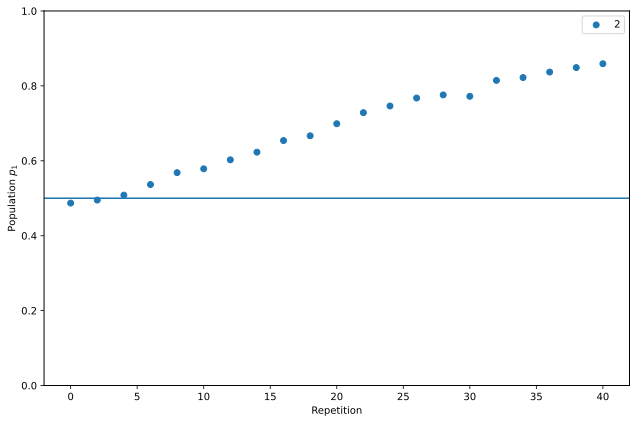

In [54]:
fig, ax = plt.subplots(ncols=1, figsize=(9, 6))

# ax.scatter(N_list, re_pop[:, 0], label='0')
# ax.scatter(N_list, re_pop[:, 1], label='1')
ax.scatter(N_list, re_pop[:, 2], label='2')
ax.axhline(0.5)
ax.set_ylim([0, 1])
ax.set_xlabel('Repetition')
ax.set_ylabel('Population $p_1$')
ax.legend()
fig.tight_layout()
fig.savefig(f'./{path}/{experiment_id}.png')

## Simulation

In [195]:
dim = 4
f_qubit = rough_01_freq/1e9
f_anhar = qubit_anharmonicty/1e9

print('Dimenions considering:', dim)
print('Qubit fundamental frequency:', f_qubit)
print('Qubit anharmonicity:', f_anhar)

Dimenions considering: 4
Qubit fundamental frequency: 4.9849775927009645
Qubit anharmonicity: -0.3071158019842663


In [196]:
omega = 2 * np.pi * f_qubit
Delta_2 = 2 * np.pi * f_anhar

In [197]:
lambda_0, lambda_1, lambda_2 = 0.089, 0.0987, 0.15 # fitted value from real Rabi oscillation experiments

Hd1 = qt.Qobj([
    [0, 0, 0, 0], 
    [0, 1, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
])

Hd2 = qt.Qobj([
    [0, 0, 0, 0], 
    [0, 0, 0, 0],
    [0, 0, 2, 0],
    [0, 0, 0, 0]
])

Hd3 = qt.Qobj([
    [0, 0, 0, 0], 
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 3]
])

H0 = qt.Qobj([
    [0, 0, 0, 0        ], 
    [0, 0, 0, 0        ],
    [0, 0, Delta_2, 0  ],
    [0, 0, 0, 3*Delta_2]
])

H1 = qt.Qobj([
    [0           , lambda_0 / 2   , 0           ,            0],
    [lambda_0 / 2, 0              , lambda_1 / 2,            0],
    [0           , lambda_1 / 2   , 0           , lambda_2 / 2],
    [0           , 0              , lambda_2 / 2,            0]
])

def add_pulse(pulse_train, pulse_name, start, tg, sigma, A):
    pulse_train[pulse_name] = {'start': start, 'tg': tg, 'sigma': sigma, 'A': A}
    pulse_train['clock'] = pulse_train['clock']+tg

def Omega(t, args):
    for item, pulse_specs in args.items():
        if item == 'clock':
            continue
        if t <= pulse_specs['start'] or t >= (pulse_specs['start'] + pulse_specs['tg']):
            continue
        else:
            t_local = t
            t_local += -pulse_specs['start'] # convert to local time of a pulse
            return pulse_specs['A'] * (np.exp(-(t_local-pulse_specs['tg']/2)**2/(2*pulse_specs['sigma']**2)) - np.exp(-pulse_specs['tg']**2/(8*pulse_specs['sigma']**2))) \
                / (1-np.exp(-pulse_specs['tg']**2/(8*pulse_specs['sigma']**2)))
    return 0

expect_ops = [qt.basis(dim, i)*qt.basis(dim, i).dag() for i in range(dim)]

In [242]:
gamma_21 = 0
gamma_10 = 0
gamma_1 = 0
gamma_2 = 8.008e-05
gamma_3 = 0

c_ops = [np.sqrt(gamma_21)*(qt.basis(dim, 1)*qt.basis(dim, 2).dag()), np.sqrt(gamma_10)*(qt.basis(dim, 0)*qt.basis(dim, 1).dag()), \
        np.sqrt(gamma_1)*(qt.basis(dim, 0)*qt.basis(dim, 0).dag()-qt.basis(dim, 1)*qt.basis(dim, 1).dag()), \
        np.sqrt(gamma_2)*(qt.basis(dim, 1)*qt.basis(dim, 1).dag()-qt.basis(dim, 2)*qt.basis(dim, 2).dag()), \
        np.sqrt(gamma_3)*(qt.basis(dim, 0)*qt.basis(dim, 0).dag()-qt.basis(dim, 2)*qt.basis(dim, 2).dag())]

pop_aae = []
psi0 = qt.basis(dim, 1) 
N0 = 21
N_list = np.array([2*n for n in range(N0)])
A0 = 0.2383838383838384 + 0.037*0.2383838383838384

for N in N_list:
    fluctuation_scale = 0
    timescale_ns = 1
    T_ns = 20 + 40 * N                        
    steps = 5000                    
    time = np.linspace(0, T_ns, steps)  

    raw_noise = np.random.normal(0, fluctuation_scale, steps)

    smoothing_sigma = steps * (timescale_ns / T_ns)
    fluctuations = gaussian_filter1d(raw_noise, sigma=smoothing_sigma)

    omega_t = omega + fluctuations

    omega_d = omega + Delta_2

    def delta(t):
        return omega_t[np.argmin(np.abs(omega_t - t))] - omega_d
    pulse_train = {'clock': 0}
    add_pulse(pulse_train, pulse_name=f'pulse_0', start=0, tg=20, sigma=20/4, A=(A0)*2*np.pi)
    for idx in range(N):
        add_pulse(pulse_train, pulse_name=f'pulse_{idx},1', start=pulse_train['clock'], tg=20, sigma=20/4, A=(A0)*2*np.pi)
        add_pulse(pulse_train, pulse_name=f'pulse_{idx},2', start=pulse_train['clock'], tg=20, sigma=20/4, A=(A0)*2*np.pi)
    args=pulse_train
    H = [H0, [H1, lambda t, args: Omega(t, args)], [Hd1, lambda t: delta(t)], [Hd2, lambda t: delta(t)], [Hd3, lambda t: delta(t)]]
    result = qt.mesolve(H, psi0, time, c_ops, expect_ops, args=args)
    pop_aae.append([result.expect[i][-1] for i in range(dim)])

pop_aae = np.array(pop_aae)

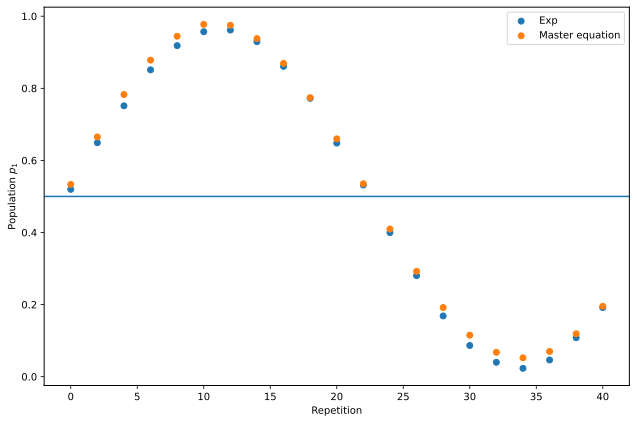

In [249]:
fig, ax = plt.subplots(ncols=1, figsize=(9, 6))

ax.scatter(N_list, pop2_exp, label='Exp')
ax.scatter(N_list, pop_aae[:, 2], label='Master equation')
ax.axhline(0.5)

ax.set_xlabel('Repetition')
ax.set_ylabel('Population $p_1$')
ax.legend()
fig.tight_layout()

fig.savefig('./paper/figures/fig1a_1fit_story.png')

In [495]:
pop2_exp = re_pop[:, 2]

In [496]:
ket0 = qt.basis(3, 0)
ket1 = qt.basis(3, 1)
ket2 = qt.basis(3, 2)

def Lx01():
    return qt.Qobj(np.array([
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 0]
    ]))

def Lz01():
    return qt.Qobj(np.array([
        [1, 0, 0],
        [0, -1, 0],
        [0, 0, 0]
    ]))

def Lx12():
    return qt.Qobj(np.array([
        [0, 0, 0],
        [0, 0, 1],
        [0, 1, 0]
    ]))

def Lz12():
    return qt.Qobj(np.array([
        [0, 0, 0],
        [0, 1, 0],
        [0, 0, -1]
    ]))

def rot_x12(a, p):
    return (-1j*((np.pi/2+a)/2)*Lx12()-1j*p*Lz12()).expm()

def coherent_error_sim(rotation_angles, optimized_a, optimized_p):

    population = []

    if optimized_p == 0:
        p = 0
        for a in rotation_angles:
            for N in N_list:
                psi0 = ket1 
                psi0 = rot_x12(a, p) * psi0
                for _ in range(N):
                    psi0 = rot_x12(a, p)*rot_x12(a, p)*psi0 

                pop1 = (np.abs(ket1.dag()*psi0).norm())**2
                pop2 = (np.abs(ket2.dag()*psi0).norm())**2

                population.append([pop1, pop2])
    else: 
        for N in N_list:
            psi0 = ket1
            psi0 = rot_x12(optimized_a, optimized_p)*psi0
            for _ in range(N):
                psi0 = rot_x12(optimized_a, optimized_p)*rot_x12(optimized_a, optimized_p)*psi0

            pop1 = (np.abs(ket1.dag()*psi0))**2
            pop2 = (np.abs(ket2.dag()*psi0))**2
            population.append([pop1, pop2])

    population = np.array(population)

    return population

def objective(args):

    a, p = args
    
    pop2_sim = []

    for N in N_list:
        psi0 = ket1
        psi0 = rot_x12(a, p)*psi0
        for _ in range(N):
            psi0 = rot_x12(a, p)*rot_x12(a, p)*psi0

        pop2 = (np.abs(ket2.dag()*psi0))**2
        pop2_sim.append(pop2)

    pop2_sim = np.array(pop2_sim)
    pop_dif = np.abs(pop2_sim - pop2_exp)**2
    print(np.average(pop_dif))
    return np.average(pop_dif)

In [497]:
from scipy.optimize import minimize

x0 = [0.03, 0.01]
solution = minimize(objective, x0, method='Nelder-Mead', tol=1e-9)

solution

0.0023305516059499228
0.012970536967985133
0.002373948625974655
0.0032167874755070678
0.001280424092327446
0.0012883876128383994
0.003246812374052707
0.001433791399074
0.001889701166686392
0.001264944781871784
0.0012702836207491917
0.0014426880719401252
0.0012503701542112482
0.0012519472520606683
0.0012843469962584256
0.001252111786600713
0.0012618032499236522
0.0012501128630570857
0.001250573344414255
0.0012500000814354023
0.0012514932862679883
0.001249992368663275
0.0012497817306137418
0.001249669536583534
0.0012502415810262957
0.001249845484994559
0.0012495116829238416
0.0012493215337322464
0.0012490375815949082
0.0012486026101871247
0.0012485627893430089
0.0012489453307222363
0.0012478653938531356
0.0012478646154237293
0.0012498663704533955
0.001248130982710735
0.0012473213684280502
0.0012477980825587411
0.0012508545098648585
0.001247625285935511
0.0012471887227316425
0.0012472102830492723
0.0012468279826437253
0.0012467281758303886
0.0012463125856880695
0.001246036305734805
0.0012

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.0010497339226441967
             x: [ 1.078e-02  1.222e-01]
           nit: 172
          nfev: 331
 final_simplex: (array([[ 1.078e-02,  1.222e-01],
                       [ 1.078e-02,  1.222e-01],
                       [ 1.078e-02,  1.222e-01]]), array([ 1.050e-03,  1.050e-03,  1.050e-03]))

In [501]:
a_test = 2.9e-02
p_test = 0

population = []
for N in N_list:
    psi0 = ket1
    psi0 = rot_x12(a_test, p_test)*psi0
    for _ in range(N):
        psi0 = rot_x12(a_test, p_test)*rot_x12(a_test, p_test)*psi0

    pop1 = (np.abs(ket1.dag()*psi0))**2
    pop2 = (np.abs(ket2.dag()*psi0))**2
    population.append([pop1, pop2])

population = np.array(population)

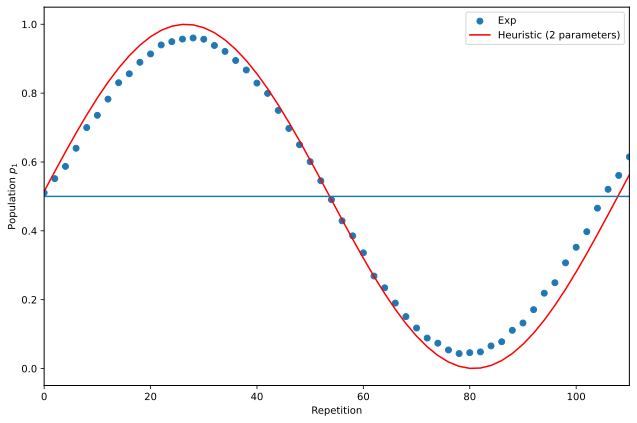

In [502]:
fig, ax = plt.subplots(ncols=1, figsize=(9, 6))

ax.scatter(N_list, pop2_exp, label='Exp')
# ax.scatter(N_list, pop_aae[:, 2], label='Master equation (3 parameters)')
ax.plot(N_list, population[:, 1], label='Heuristic (2 parameters)', color='red')
ax.axhline(0.5)

ax.set_xlim([0, 110])
ax.set_xlabel('Repetition')
ax.set_ylabel('Population $p_1$')
ax.legend()
fig.tight_layout()

# fig.savefig('./paper/figures/fig1a_2fits_story.png')

In [469]:
epsilon = 2.9e-02

amp_prim = 0.2398989898989899/(1+2*epsilon/np.pi)

amp_prim

0.2355502671331308